In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

plt.ion()

In [215]:
class PlanarFlow(nn.Module):
    """
    Planar flow transformation, described in equations (10) - (12) in https://arxiv.org/pdf/1505.05770.pdf
    We use tanh activation (h) function.
    """
    
    def __init__(self, z_dim):
        super(PlanarFlow, self).__init__()
        
        self.z_dim = z_dim
        self.h = nn.Tanh()
        
        self.u = Parameter(torch.randn(z_dim))
        self.fc = nn.Linear(z_dim, 1)
    
    def forward(self, z, logp):
        """
        Given a set of samples z and their respective log probabilities, returns 
        z' = f(z) and log p(z'), as described by the equations in the paper.
        Sizes should be (L, z_dim) and (L), respectively.
        Outputs are the same size as the inputs.
        """
        
        a = self.h(self.fc(z))
        psi = torch.mm((1 - a ** 2), self.fc.weight) # derivative of tanh(x) is 1 - tanh^2(x)
        logp = logp - torch.log(torch.abs(1 + torch.sum(psi * self.u, 1)))
        z = z + a * self.u
        
        return z, logp
    
    def transform(self, z):
        """
        Same as forward, but doesn't compute logp transformation.
        Faster when we only care about e.g. sampling.
        """
        
        return z + self.h(self.fc(z)) * self.u
    

In [216]:
class NormFlow(nn.Module):
    """
    Normalizing flow (composition of individual transforms), as described in equation (13) of the paper
    """
    def __init__(self, z_dim):
        super(NormFlow, self).__init__()
        
        self.z_dim = z_dim
        self.flows = nn.ModuleList()
    
    def add_flow(self, flow_type, K = 1):
        """
        Adds K copies of flows of type flow_type to the overall normalizing flow.
        flow_type can be either PlanarFlow or RadialFlow
        """
        for k in range(K):
            flow = flow_type(self.z_dim)
            self.flows.append(flow)
    
    def forward(self, z, logp):
        """
        Given a set of samples z and their respective log probabilities, returns 
        the corresponding values z_K = f_K ○ f_(K-1) ○ ... ○ f_1(z), as well as 
        the respective log probabilities log p_K(z_K).
        Sizes should be (L, z_dim) and (L), respectively.
        Outputs are the same size as the inputs.
        """
        
        for flow in self.flows: z, logp = flow(z, logp)
        return z, logp
    
    def transform(self, z):
        for flow in self.flows: z = flow.transform(z)
        return z
    

In [221]:
class Trainer:
    # wrapper over normalizing flow where we train
    def __init__(self, z_dim, model, save_path = None):
        self.z_dim = z_dim
        
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters())
        
        if save_path is not None: self.save_path = '../ckpts/' + save_path
        else: self.save_path = '../ckpts/normflow_z={}/'.format(z_dim)
    
    def save_model(self):
        if not os.path.exists(self.save_path): os.makedirs(self.save_path)
        torch.save(self.model.state_dict(), self.save_path + 'model')
        torch.save(self.optimizer.state_dict(), self.save_path + 'optimizer')
    
    def load_model(self):
        if not os.path.exists(self.save_path): return
        self.model.load_state_dict(torch.load(self.save_path + 'model'))
        self.optimizer.load_state_dict(torch.load(self.save_path + 'optimizer'))
    
    def train(self, U, L = 1, num_epochs = 100, every_epoch = 10):
        """
        Trains the normalizing flow to match p(z) = exp(-U(z)) / Z
        Note z0 ~ N(0, 1)
        U is assumed to be a function that takes input of size (L, z_dim) and output size (L)
        z_dim will be 2 in our case.
        Also, since there's no dataset (rather a function), we'll just assume each epoch is 100 updates
        """
        
        epoch_length = 100
        self.loss_data = []
        for epoch in range(1, num_epochs + 1):
            running_loss = 0
            for i in range(epoch_length):
                self.optimizer.zero_grad()
                
                z_0 = Variable(torch.randn(L, self.z_dim))
                logq_0 = -0.5 * (torch.sum(z_0 ** 2, 1) + self.z_dim * np.log(2 * np.pi)) # log Gaussian
                z_k, logq_k = self.model(z_0, logq_0)
                loss = torch.sum(U(z_k) + logq_k) / L
                running_loss += loss.data[0]
                
                loss.backward()
                self.optimizer.step()
            
            running_loss /= epoch_length
            if epoch % every_epoch == 0:
                print("Epoch {} Loss: {}".format(epoch, running_loss))
            self.loss_data.append(running_loss)
    

In [222]:
# All the following functions take inputs of size (L, z_dim) and outputs size (L)

def w1(z):
    return torch.sin(2 * np.pi * z[:, 0] / 4)

def w2(z):
    return 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.6) ** 2)

def w3(z):
    return 3 * torch.sigmoid((z[:, 0] - 1) / 0.3)

def U1(z):
    add1 = 0.5 * ((torch.norm(z, 2, 1) - 2) / 0.4) ** 2
    add2 = -torch.log(torch.exp(-0.5 * ((z[:, 0] - 2) / 0.6) ** 2) + torch.exp(-0.5 * ((z[:, 0] + 2) / 0.6) ** 2))
    return add1 + add2

def U2(z):
    return 0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2

def U3(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    return -torch.log(in1 + in2)

def U4(z):
    in1 = torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.4) ** 2)
    in2 = torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    return -torch.log(in1 + in2)

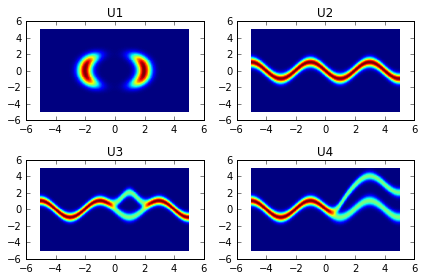

In [219]:
def plot_potential(U, ax):
    side = np.linspace(-5, 5, 500)
    X, Y = np.meshgrid(side, side)
    shape = X.shape
    X_flatten, Y_flatten = np.reshape(X, (-1, 1)), np.reshape(Y, (-1, 1))
    Z = np.concatenate([X_flatten, Y_flatten], 1)
    neg_logp = U(torch.Tensor(Z)).numpy()
    neg_logp = np.reshape(neg_logp, shape)
    p = np.exp(-neg_logp)
    p /= np.sum(p)
    Y = -Y # not sure why, but my plots are upside down compared to paper
    ax.pcolormesh(X, Y, p)

fig, axes = plt.subplots(2, 2)

for U, ax in zip([U1, U2, U3, U4], axes.flatten()):
    plot_potential(U, ax)
    ax.set_title(U.__name__)

fig.tight_layout()
plt.show()
    

In [232]:
model1 = NormFlow(2)
model1.add_flow(PlanarFlow, K = 32)
trainer1 = Trainer(2, model1)
trainer1.train(U1, L = 10, num_epochs = 100)

Epoch 10 Loss: -1.0955857175588608
Epoch 20 Loss: -1.1432197761535645
Epoch 30 Loss: -1.1555257391929628
Epoch 40 Loss: -1.1621528047323226
Epoch 50 Loss: -1.1618660300970078
Epoch 60 Loss: -1.170747196674347
Epoch 70 Loss: -1.1708828115463257
Epoch 80 Loss: -1.1672074580192566
Epoch 90 Loss: -1.1821159946918487
Epoch 100 Loss: -1.1702381640672683


Sampling..........

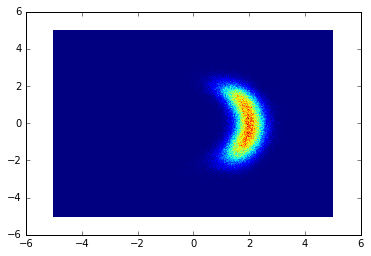

In [233]:
def plot_model(model, ax):
    """
    We sample a bunch of points z0 ~ N(0, 1) and transform them through the normalizing flow, 
    to get an empirical distribution, which we then plot
    """
    side = np.linspace(-5, 5, 500)
    X, Y = np.meshgrid(side, side)
    counts = np.zeros(X.shape)
    
    L = 100000 # batch of points to sample at once
    z_dim = 2
    N = 0
    print("Sampling", end='')
    for i in range(10):
        print('.', end='')
        z = Variable(torch.randn(L, z_dim))
        z = model.transform(z).data
        z = (z + 5) * 50
        for l in range(L):
            x, y = int(z[l][1]), int(z[l][0])
            if 0 <= x and x < 500 and 0 <= y and y < 500:
                counts[x][y] += 1
        N += L
    
    p = counts / N
    Y = -Y # not sure why, but my plots are upside down compared to paper
    ax.pcolormesh(X, Y, p)

'''
fig, axes = plt.subplots(2, 2)

for U, ax in zip([U1, U2, U3, U4], axes.flatten()):
    plot_potential(U, ax)
    ax.set_title(U.__name__)

fig.tight_layout()
plt.show()
'''

fig, ax = plt.subplots(1, 1)
plot_model(model1, ax)
    